  # Neural Network Training for the actuarial approach

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import fsolve
import joblib
import matplotlib.pyplot as plt 

plt.style.use('bmh')

import matplotlib
matplotlib.rcParams.update({'font.size': 16})

from tqdm import tqdm
%load_ext autoreload
%autoreload 2
%aimport IS_misc_functions
from IS_misc_functions import *
from misc_functions import *
from actuarial_training import *

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler,normalize
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import json

### Create the neural network

In [10]:
def build_model(x,nr_neurons = 256,regul = 0.00):

    model = keras.Sequential([
        layers.Dense(nr_neurons,kernel_regularizer=regularizers.l2(regul),activation='relu',input_shape=[401]),
        layers.Dropout(0.2),
        layers.Dense(nr_neurons,kernel_regularizer=regularizers.l2(regul), activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(nr_neurons,kernel_regularizer=regularizers.l2(regul), activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(nr_neurons,kernel_regularizer=regularizers.l2(regul), activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1)
      ])
    opt1 = tf.keras.optimizers.Adam(learning_rate = 0.0005, beta_1=0.9, beta_2=0.999)
    model.compile(loss=tf.keras.losses.MeanSquaredError(), #tf.keras.losses.MeanAbsolutePercentageError(), #mse',
                    optimizer=opt1,
                    metrics=[tf.keras.losses.MeanAbsoluteError(), tf.keras.losses.MeanSquaredError()])
    scaler = StandardScaler().fit(x)
    return model, scaler

### Load the Training Data

In [3]:
# # Read Data
def read_data(xpath,ypath):
    df_x = pd.read_csv(xpath, header=None)
    df_x = df_x.dropna()
    df_x = df_x.iloc[:,1:]

    df_y = pd.read_csv(ypath, header=None)
    df_y = df_y.dropna()
    df_y = df_y.iloc[:,1:]
    
    return df_x,df_y
x,y = read_data("csv/X_1.csv","csv/Y_1.csv")
for i in range(2,11):
    x_new,y_new = read_data("csv/X_"+str(i)+".csv","csv/Y_"+str(i)+".csv")
    x = pd.concat([x,x_new])
    y = pd.concat([y,y_new])
x_train = x.reset_index(drop = True)
y_train = y.reset_index(drop = True)

x_test, y_test = read_data("csv/X_test.csv","csv/Y_test.csv")



# Load the pretrained GA-Approx

In [4]:
x_train_approx = pd.read_csv("csv/X_Train_act_approx.csv", header=None).iloc[1:,1].reset_index(drop = True)
x_test_approx = pd.read_csv("csv/X_Test_act_approx.csv", header=None).iloc[1:,1]

Add to the training and test set, respectively

In [5]:
x_train = pd.concat([x_train,x_train_approx],axis = 1)
x_test = pd.concat([x_test,x_test_approx],axis = 1)

### Train the neural network

In [58]:
# Train the model
EPOCHS = 1000
neurons = 512
regul = 0.00
BATCH_SIZE = 32

model, scaler = build_model(x_train,neurons,regul)
joblib.dump(scaler, 'scaler_actuarial.gz')
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=200)

# # Fit the Data
history = model.fit(x_train_scaled, y_train,  epochs=EPOCHS,batch_size = BATCH_SIZE,
                    validation_split = 0.1, verbose=1,callbacks = [early_stop])


Epoch 1/1000
282/282 [==============================] - 6s 18ms/step - loss: 0.0265 - mae: 0.0913 - mse: 0.0265 - val_loss: 0.0011 - val_mae: 0.0258 - val_mse: 0.0011
Epoch 2/1000
282/282 [==============================] - 5s 18ms/step - loss: 0.0026 - mae: 0.0385 - mse: 0.0026 - val_loss: 4.9272e-04 - val_mae: 0.0157 - val_mse: 4.9272e-04
Epoch 3/1000
282/282 [==============================] - 5s 18ms/step - loss: 0.0012 - mae: 0.0264 - mse: 0.0012 - val_loss: 4.9762e-04 - val_mae: 0.0154 - val_mse: 4.9762e-04
Epoch 4/1000
282/282 [==============================] - 5s 18ms/step - loss: 7.2755e-04 - mae: 0.0201 - mse: 7.2755e-04 - val_loss: 5.3829e-04 - val_mae: 0.0165 - val_mse: 5.3829e-04
Epoch 5/1000
282/282 [==============================] - 5s 18ms/step - loss: 4.6995e-04 - mae: 0.0158 - mse: 4.6995e-04 - val_loss: 3.4470e-04 - val_mae: 0.0124 - val_mse: 3.4470e-04
Epoch 6/1000
282/282 [==============================] - 6s 20ms/step - loss: 3.4312e-04 - mae: 0.0132 - mse: 3.4312e-

Epoch 46/1000
282/282 [==============================] - 5s 18ms/step - loss: 9.2774e-05 - mae: 0.0062 - mse: 9.2774e-05 - val_loss: 9.5172e-05 - val_mae: 0.0066 - val_mse: 9.5172e-05
Epoch 47/1000
282/282 [==============================] - 5s 17ms/step - loss: 8.1080e-05 - mae: 0.0060 - mse: 8.1080e-05 - val_loss: 1.4442e-04 - val_mae: 0.0085 - val_mse: 1.4442e-04
Epoch 48/1000
282/282 [==============================] - 5s 17ms/step - loss: 7.4625e-05 - mae: 0.0058 - mse: 7.4625e-05 - val_loss: 9.9838e-05 - val_mae: 0.0066 - val_mse: 9.9838e-05
Epoch 49/1000
282/282 [==============================] - 5s 19ms/step - loss: 8.5955e-05 - mae: 0.0060 - mse: 8.5955e-05 - val_loss: 9.2616e-05 - val_mae: 0.0061 - val_mse: 9.2616e-05
Epoch 50/1000
282/282 [==============================] - 5s 17ms/step - loss: 8.3067e-05 - mae: 0.0060 - mse: 8.3067e-05 - val_loss: 9.9077e-05 - val_mae: 0.0070 - val_mse: 9.9077e-05
Epoch 51/1000
282/282 [==============================] - 5s 17ms/step - loss: 8.

282/282 [==============================] - 5s 19ms/step - loss: 3.8179e-05 - mae: 0.0042 - mse: 3.8179e-05 - val_loss: 7.0300e-05 - val_mae: 0.0053 - val_mse: 7.0300e-05
Epoch 135/1000
282/282 [==============================] - 5s 17ms/step - loss: 3.9873e-05 - mae: 0.0042 - mse: 3.9873e-05 - val_loss: 8.2054e-05 - val_mae: 0.0051 - val_mse: 8.2054e-05
Epoch 136/1000
282/282 [==============================] - 5s 18ms/step - loss: 3.5531e-05 - mae: 0.0040 - mse: 3.5531e-05 - val_loss: 9.1738e-05 - val_mae: 0.0057 - val_mse: 9.1738e-05
Epoch 137/1000
282/282 [==============================] - 5s 19ms/step - loss: 4.2339e-05 - mae: 0.0043 - mse: 4.2339e-05 - val_loss: 9.0351e-05 - val_mae: 0.0056 - val_mse: 9.0351e-05
Epoch 138/1000
282/282 [==============================] - 5s 17ms/step - loss: 4.1978e-05 - mae: 0.0043 - mse: 4.1978e-05 - val_loss: 8.2344e-05 - val_mae: 0.0053 - val_mse: 8.2344e-05
Epoch 139/1000
282/282 [==============================] - 5s 17ms/step - loss: 3.6346e-05 

282/282 [==============================] - 5s 17ms/step - loss: 3.3315e-05 - mae: 0.0039 - mse: 3.3315e-05 - val_loss: 9.8226e-05 - val_mae: 0.0058 - val_mse: 9.8226e-05
Epoch 223/1000
282/282 [==============================] - 5s 16ms/step - loss: 3.9367e-05 - mae: 0.0040 - mse: 3.9367e-05 - val_loss: 8.8738e-05 - val_mae: 0.0054 - val_mse: 8.8738e-05
Epoch 224/1000
282/282 [==============================] - 5s 17ms/step - loss: 3.2875e-05 - mae: 0.0039 - mse: 3.2875e-05 - val_loss: 8.0425e-05 - val_mae: 0.0056 - val_mse: 8.0425e-05
Epoch 225/1000
282/282 [==============================] - 5s 18ms/step - loss: 3.5619e-05 - mae: 0.0039 - mse: 3.5619e-05 - val_loss: 7.6690e-05 - val_mae: 0.0050 - val_mse: 7.6690e-05
Epoch 226/1000
282/282 [==============================] - 5s 16ms/step - loss: 3.8235e-05 - mae: 0.0039 - mse: 3.8235e-05 - val_loss: 7.8277e-05 - val_mae: 0.0055 - val_mse: 7.8277e-05
Epoch 227/1000
282/282 [==============================] - 5s 16ms/step - loss: 3.5647e-05 

282/282 [==============================] - 5s 17ms/step - loss: 3.1071e-05 - mae: 0.0037 - mse: 3.1071e-05 - val_loss: 7.7577e-05 - val_mae: 0.0056 - val_mse: 7.7577e-05
Epoch 311/1000
282/282 [==============================] - 5s 18ms/step - loss: 2.9439e-05 - mae: 0.0036 - mse: 2.9439e-05 - val_loss: 7.9654e-05 - val_mae: 0.0057 - val_mse: 7.9654e-05
Epoch 312/1000
282/282 [==============================] - 5s 16ms/step - loss: 3.1220e-05 - mae: 0.0038 - mse: 3.1220e-05 - val_loss: 7.9267e-05 - val_mae: 0.0055 - val_mse: 7.9267e-05
Epoch 313/1000
282/282 [==============================] - 4s 16ms/step - loss: 3.3918e-05 - mae: 0.0038 - mse: 3.3918e-05 - val_loss: 7.3798e-05 - val_mae: 0.0050 - val_mse: 7.3798e-05
Epoch 314/1000
282/282 [==============================] - 5s 18ms/step - loss: 3.0316e-05 - mae: 0.0037 - mse: 3.0316e-05 - val_loss: 7.6550e-05 - val_mae: 0.0053 - val_mse: 7.6550e-05
Epoch 315/1000
282/282 [==============================] - 5s 17ms/step - loss: 3.3620e-05 

282/282 [==============================] - 5s 17ms/step - loss: 4.1975e-05 - mae: 0.0040 - mse: 4.1975e-05 - val_loss: 8.6541e-05 - val_mae: 0.0054 - val_mse: 8.6541e-05
Epoch 399/1000
282/282 [==============================] - 5s 17ms/step - loss: 3.4637e-05 - mae: 0.0038 - mse: 3.4637e-05 - val_loss: 7.2956e-05 - val_mae: 0.0053 - val_mse: 7.2956e-05
Epoch 400/1000
282/282 [==============================] - 5s 18ms/step - loss: 3.3266e-05 - mae: 0.0038 - mse: 3.3266e-05 - val_loss: 7.6718e-05 - val_mae: 0.0051 - val_mse: 7.6718e-05
Epoch 401/1000
282/282 [==============================] - 5s 18ms/step - loss: 3.3365e-05 - mae: 0.0038 - mse: 3.3365e-05 - val_loss: 6.9120e-05 - val_mae: 0.0049 - val_mse: 6.9120e-05
Epoch 402/1000
282/282 [==============================] - 5s 17ms/step - loss: 3.3238e-05 - mae: 0.0037 - mse: 3.3238e-05 - val_loss: 7.7401e-05 - val_mae: 0.0052 - val_mse: 7.7401e-05
Epoch 403/1000
282/282 [==============================] - 5s 18ms/step - loss: 3.0484e-05 

282/282 [==============================] - 5s 16ms/step - loss: 3.8101e-05 - mae: 0.0039 - mse: 3.8101e-05 - val_loss: 8.1570e-05 - val_mae: 0.0057 - val_mse: 8.1570e-05
Epoch 487/1000
282/282 [==============================] - 5s 18ms/step - loss: 4.0003e-05 - mae: 0.0040 - mse: 4.0003e-05 - val_loss: 7.3593e-05 - val_mae: 0.0053 - val_mse: 7.3593e-05
Epoch 488/1000
282/282 [==============================] - 5s 17ms/step - loss: 4.2417e-05 - mae: 0.0041 - mse: 4.2417e-05 - val_loss: 8.1175e-05 - val_mae: 0.0052 - val_mse: 8.1175e-05
Epoch 489/1000
282/282 [==============================] - 5s 16ms/step - loss: 4.2592e-05 - mae: 0.0040 - mse: 4.2592e-05 - val_loss: 1.0139e-04 - val_mae: 0.0060 - val_mse: 1.0139e-04
Epoch 490/1000
282/282 [==============================] - 5s 18ms/step - loss: 3.7328e-05 - mae: 0.0039 - mse: 3.7328e-05 - val_loss: 8.3384e-05 - val_mae: 0.0056 - val_mse: 8.3384e-05
Epoch 491/1000
282/282 [==============================] - 5s 17ms/step - loss: 4.1933e-05 

# Evaluation

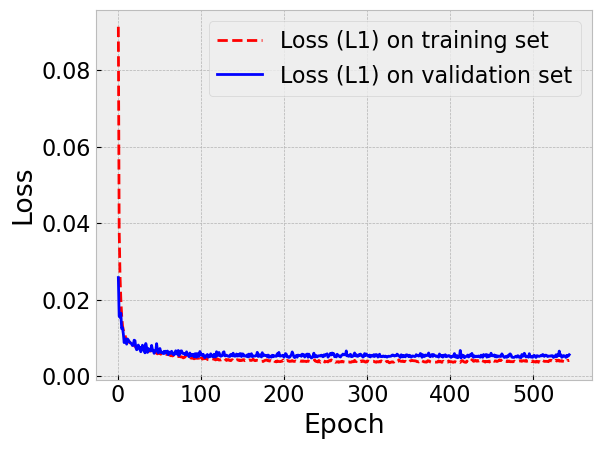

Prediction
1/1 [==============================] - 0s 79ms/step
[[0.06855811]
 [0.02947604]
 [0.02115721]
 [0.10740767]
 [0.025104  ]]
True Values
            1
274  0.064467
665  0.030663
703  0.020941
98   0.104593
173  0.021829
32/32 [==============================] - 0s 4ms/step
Model Evaluation
32/32 - 0s - loss: 8.9098e-05 - mae: 0.0057 - mse: 8.9098e-05 - 148ms/epoch - 5ms/step
[8.909778262022883e-05, 0.005651140585541725, 8.909778262022883e-05]


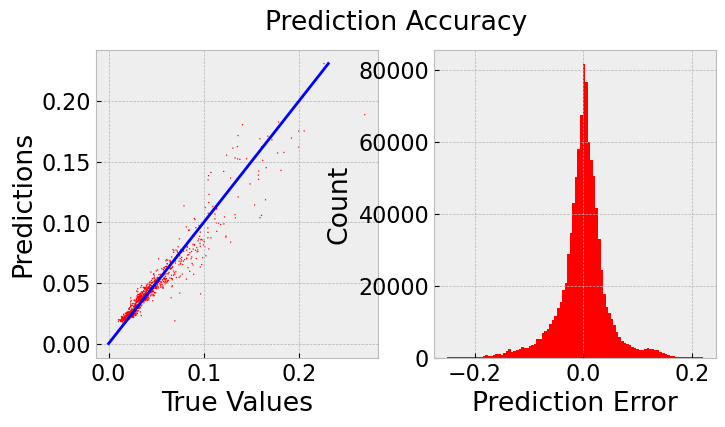

In [59]:
# Plot the training process
training_loss = history.history["mae"]

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)
# Visualize loss history
plt.plot(epoch_count, training_loss, "r--")

val_loss = history.history["val_mae"]
plt.plot(epoch_count, val_loss, "b-")

plt.legend(["Loss (L1) on training set", "Loss (L1) on validation set"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
#plt.savefig('history_spot_many_options.eps', format='eps')
plt.show()

# Make a single Prediction
indices = [max(round(float(np.random.sample(1)*(len(x_test)-1))),0) for i in range(5)]
print("Prediction")
print(model.predict(x_test_scaled[indices]))
print("True Values")
print(y_test.iloc[indices])



# Plot the errors
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
#Along a line
test_predictions = model.predict(x_test_scaled).flatten()
#a = plt.axes(aspect='equal')
axs[0].plot([0,max(test_predictions)],[0,max(test_predictions)],color = "blue")
axs[0].scatter(y_test, test_predictions, c='red',s=1, edgecolors='None')
axs[0].set_xlabel('True Values')
axs[0].set_ylabel('Predictions')

# Histogram
error = np.array(model.predict(x_test_scaled).reshape(-1,) - np.array(y_test)).flatten()
axs[1].hist(error, bins = 100,color = 'red')
axs[1].set_xlabel("Prediction Error")
axs[1].set_ylabel("Count")
fig.suptitle('Prediction Accuracy')
#plt.savefig('accuracy_spot_many_options.eps', format='eps')

# Model Evaluation
print("Model Evaluation")
print(model.evaluate(x_test_scaled, y_test, verbose=2))
# Percentage Error

Save the model

In [60]:
model.save("model_actuarial_0999.h5")

### Compute GA approx on Test set

In [61]:
GA_List_999 = []
GA_List_small_999 = []
GA_approx_List_999 = []
GA_NN_List_999 = []
GA_approx_List_small_999 = []
GA_NN_List_small_999 = []


for i in range(len(x_test)):
    GA_approx_List_999.append(x_test_approx.iloc[i])                              
    GA_NN_List_999.append(model.predict(np.reshape(x_test_scaled[i,:],(1,401))))
    GA_List_999.append(y_test.iloc[i,:])
                              
    N_obligors = np.sum(x_test.iloc[i,:100]>0)                               
    small_threshold = 25 # Set Threshold to 25 obligors
    if N_obligors < small_threshold:
        GA_List_small_999.append(GA_List_999[-1])
        GA_approx_List_small_999.append(GA_approx_List_999[-1])
        GA_NN_List_small_999.append(GA_NN_List_999[-1])     
        
GA_List_999 = [float(GA_List_999[i]) for i in range(len(GA_List_999))]
GA_List_small_999 = [float(GA_List_small_999[i]) for i in range(len(GA_List_small_999))]

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 23ms/step


### Error of NN

In [62]:
diff_MC_NN_999 = np.array([np.abs(i[0]-j) for i,j in zip(GA_NN_List_999,GA_List_999)])
pd.DataFrame(diff_MC_NN_999).describe()

,0
count,1.000000e+03
mean,5.651142e-03
std,7.564365e-03
min,2.384186e-07
25%,1.618461e-03
50%,3.512009e-03
75%,6.584000e-03
max,8.046494e-02


### Error of GA approx

In [63]:
diff_approx_exact_999 = np.array([np.abs(i-j) for i,j in zip(GA_List_999,GA_approx_List_999)])
pd.DataFrame(diff_approx_exact_999).describe()

,0
count,1000.000000
mean,0.048969
std,0.063463
min,0.000196
25%,0.016958
50%,0.028135
75%,0.054627
max,0.823225


### Error of NN on small portfolios

In [64]:
diff_MC_NN_small_999 = np.array([np.abs(i[0]-j) for i,j in zip(GA_NN_List_small_999,GA_List_small_999) ])
pd.DataFrame(diff_MC_NN_small_999).describe()

,0
count,166.000000
mean,0.012746
std,0.013928
min,0.000024
25%,0.002946
50%,0.007484
75%,0.018182
max,0.080465


### Error of GA approx on small portfolios

In [65]:
diff_approx_exact_small_999 = np.array([np.abs(i-j) for i,j in zip(GA_List_small_999,GA_approx_List_small_999)])
pd.DataFrame(diff_approx_exact_small_999).describe()

,0
count,166.000000
mean,0.138602
std,0.108785
min,0.004460
25%,0.074412
50%,0.104329
75%,0.165659
max,0.823225


### Plot the error of GA Approx

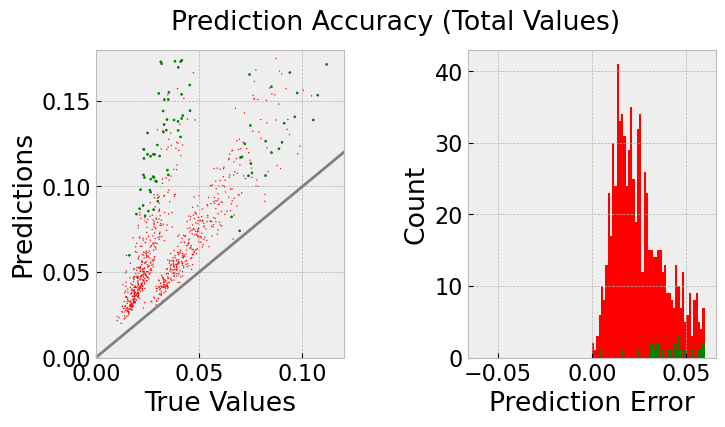

In [66]:
xmax = 0.12
xmin = -xmax
# Plot the errors
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
plt.subplots_adjust(wspace=0.5)
#Along a line
#a = plt.axes(aspect='equal')
axs[0].plot([0,xmax],[0,xmax],color = "gray") #,linestyle = "dashed")


axs[0].scatter(GA_List_999, GA_approx_List_999, c=['red']*len(GA_List_999),s=1, edgecolors='None')
axs[0].scatter(GA_List_small_999, GA_approx_List_small_999, c=['green']*len(GA_List_small_999),s=2) #, edgecolors='None')
axs[0].set_xlabel('True Values')
axs[0].set_ylabel('Predictions')
axs[0].set_ylabel('Predictions')
axs[0].set_xlim([0,xmax])
axs[0].set_ylim([0,1.5*xmax])

# Histogram
error = np.array(GA_approx_List_999) - np.array(GA_List_999)
error_small = np.array(GA_approx_List_small_999) - np.array(GA_List_small_999)
axs[1].hist(error, bins = 100,color='red',range=[xmin*0.5,xmax*0.5])
axs[1].hist(error_small, bins = 100,color='green',range=[xmin*0.5,xmax*0.5])
axs[1].set_xlabel("Prediction Error")
axs[1].set_ylabel("Count")
fig.suptitle('Prediction Accuracy (Total Values)')
plt.savefig('Plots/actuarial_approx_0999.eps', format='eps',bbox_inches='tight')
plt.savefig('Plots/actuarial_approx_0999.pdf', format='pdf',bbox_inches='tight')

### Plot the error of the NN

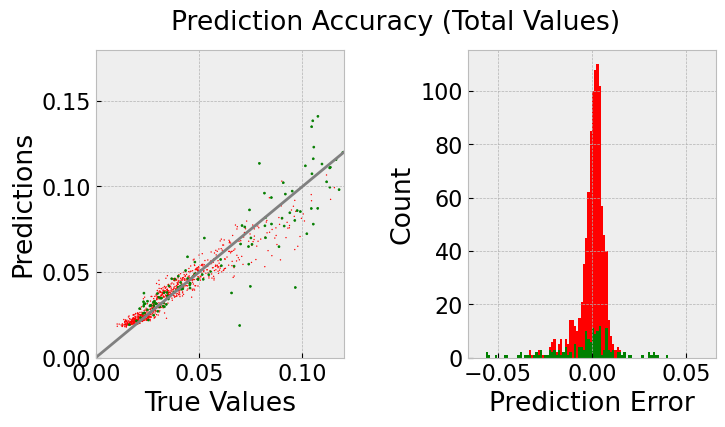

In [67]:
# Plot the errors
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
plt.subplots_adjust(wspace=0.5)
#Along a line
#a = plt.axes(aspect='equal')
axs[0].plot([0,xmax],[0,xmax],color = "gray") #,linestyle = "dashed")


axs[0].scatter(GA_List_999, GA_NN_List_999, c=['red']*len(GA_List_999),s=1, edgecolors='None')
axs[0].scatter(GA_List_small_999, GA_NN_List_small_999, c=['green']*len(GA_List_small_999),s=2) #, edgecolors='None')
axs[0].set_xlabel('True Values')
axs[0].set_ylabel('Predictions')
axs[0].set_xlim([0,xmax])
axs[0].set_ylim([0,1.5*xmax])

# Histogram
error = np.array(GA_NN_List_999).flatten() - np.array(GA_List_999).flatten()
error_small = np.array(GA_NN_List_small_999).flatten() - np.array(GA_List_small_999).flatten()
axs[1].hist(error, bins = 100,color='red',range=[xmin*0.5,xmax*0.5])
axs[1].hist(error_small, bins = 100,color='green',range=[xmin*0.5,xmax*0.5])
axs[1].set_xlabel("Prediction Error")
axs[1].set_ylabel("Count")
fig.suptitle('Prediction Accuracy (Total Values)')
plt.savefig('Plots/actuarial_NN_0999.eps', format='eps',bbox_inches='tight')
plt.savefig('Plots/actuarial_NN_0999.pdf', format='pdf',bbox_inches='tight')

### Produce Latex Table: Error on all portfolios

In [68]:
table_tex_1 = pd.concat([pd.DataFrame(diff_MC_NN_999).describe(),
                         pd.DataFrame(diff_approx_exact_999).describe()],axis = 1)
table_tex_1.columns = ['q = 99.9%,|GA NN - GA MC|',
                       'q = 99.9%, |GA Approx. - GA MC|']
#print(tabulate(table_tex_1, tablefmt="latex"))
print(table_tex_1.round(5).to_latex())

\begin{tabular}{lrr}
\toprule
{} &  q = 99.9\%,|GA NN - GA MC| &  q = 99.9\%, |GA Approx. - GA MC| \\
\midrule
count &                 1000.00000 &                       1000.00000 \\
mean  &                    0.00565 &                          0.04897 \\
std   &                    0.00756 &                          0.06346 \\
min   &                    0.00000 &                          0.00020 \\
25\%   &                    0.00162 &                          0.01696 \\
50\%   &                    0.00351 &                          0.02814 \\
75\%   &                    0.00658 &                          0.05463 \\
max   &                    0.08046 &                          0.82322 \\
\bottomrule
\end{tabular}



C:\Users\jul_ses\AppData\Local\Temp\ipykernel_932\4192034481.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table_tex_1.round(5).to_latex())


### Produce Latex Table: Error on small portfolios

In [69]:
table_tex_2 = pd.concat([
                         pd.DataFrame(diff_MC_NN_small_999).describe(),
                         pd.DataFrame(diff_approx_exact_small_999).describe()],axis = 1)
table_tex_2.columns = ['%q = 99.9%,~|GA NN - GA MC|$',
                       '%q = 99.9%,~|GA Approx. - GA MC|$']
#print(tabulate(table_tex_2, tablefmt="latex"))
print(table_tex_2.round(5).to_latex())

\begin{tabular}{lrr}
\toprule
{} &  \%q = 99.9\%,\textasciitilde |GA NN - GA MC|\$ &  \%q = 99.9\%,\textasciitilde |GA Approx. - GA MC|\$ \\
\midrule
count &                     166.00000 &                          166.00000 \\
mean  &                       0.01275 &                            0.13860 \\
std   &                       0.01393 &                            0.10879 \\
min   &                       0.00002 &                            0.00446 \\
25\%   &                       0.00295 &                            0.07441 \\
50\%   &                       0.00748 &                            0.10433 \\
75\%   &                       0.01818 &                            0.16566 \\
max   &                       0.08046 &                            0.82322 \\
\bottomrule
\end{tabular}



C:\Users\jul_ses\AppData\Local\Temp\ipykernel_932\2257743522.py:7: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table_tex_2.round(5).to_latex())
